Dataset loaded: (14368, 43)
Adjusted Rand Index: -9.479954483349584e-05


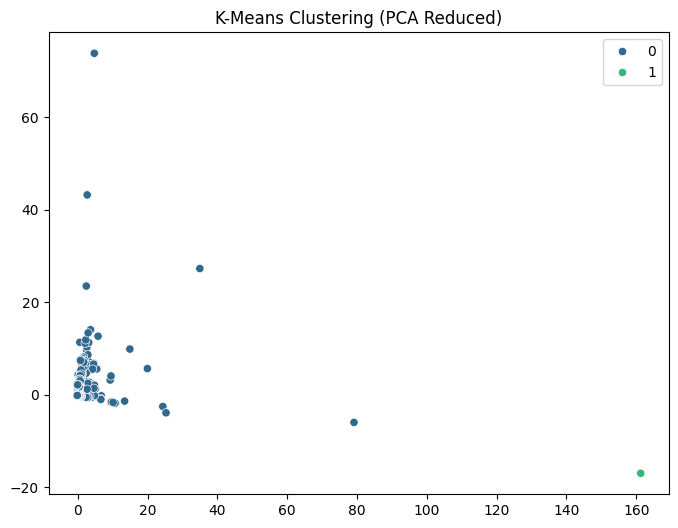

In [3]:
# --- STEP 1: Imports ---
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- STEP 2: Load all user datasets ---
data_path = "../data"

files = {
    "genuine": "genuine_accounts_users.csv",
    "fake_followers": "fake_followers_users.csv",
    "social_spambots_1": "social_spambots1_users.csv",
    "social_spambots_2": "social_spambots2_users.csv",
    "social_spambots_3": "social_spambots3_users.csv",
    "traditional_spambots_1": "traditional_spambots1_users.csv",
    "traditional_spambots_2": "traditional_spambots2_users.csv",
    "traditional_spambots_3": "traditional_spambots3_users.csv",
    "traditional_spambots_4": "traditional_spambots4_users.csv",
}

all_dfs = []

for label, file in files.items():
    file_path = os.path.join(data_path, file)
    df = pd.read_csv(file_path)
    df["label"] = 0 if label == "genuine" else 1
    all_dfs.append(df)

# Combine all datasets
full_df = pd.concat(all_dfs, ignore_index=True)
print("Dataset loaded:", full_df.shape)

# --- STEP 3: Feature engineering ---
features = pd.DataFrame()

features["followers"] = full_df["followers_count"]
features["following"] = full_df["friends_count"]
features["statuses"] = full_df["statuses_count"]
features["followers_following_ratio"] = full_df["followers_count"] / (full_df["friends_count"] + 1)
features["listed_count"] = full_df.get("listed_count", pd.Series(0, index=full_df.index))

# Fill NA and infinite values
features = features.fillna(0)
features = features.replace([np.inf, -np.inf], 0)

# --- STEP 4: Scale features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# --- STEP 5: K-Means clustering ---
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_scaled)
labels = kmeans.labels_

# --- STEP 6: Evaluate clustering ---
true_labels = full_df["label"]
ari = adjusted_rand_score(true_labels, labels)
print("Adjusted Rand Index:", ari)

# --- STEP 7: Visualize with PCA ---
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette="viridis")
plt.title("K-Means Clustering (PCA Reduced)")
plt.show()

DBSCAN found clusters: 1
Adjusted Rand Index (DBSCAN): 0.0


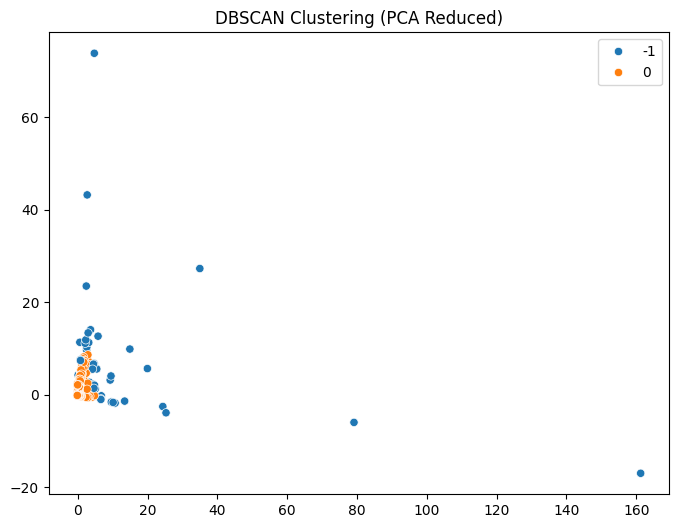

In [4]:
# --- DBSCAN Clustering ---
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=2, min_samples=5)  # eps may need tuning
db_labels = dbscan.fit_predict(X_scaled)

# Check how many clusters
n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
print("DBSCAN found clusters:", n_clusters)

# Evaluate (ignore noise points for ARI)
mask = db_labels != -1
if mask.sum() > 0:
    ari_dbscan = adjusted_rand_score(true_labels[mask], db_labels[mask])
    print("Adjusted Rand Index (DBSCAN):", ari_dbscan)
else:
    print("No clusters found (all noise).")

# Visualize DBSCAN clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=db_labels, palette="tab10", legend="full")
plt.title("DBSCAN Clustering (PCA Reduced)")
plt.show()


/var/folders/cn/kklpt8s55zx1q68hpknb0khm0000gn/T/ipykernel_86304/249903816.py:8: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, encoding='latin1')
/var/folders/cn/kklpt8s55zx1q68hpknb0khm0000gn/T/ipykernel_86304/249903816.py:8: DtypeWarning: Columns (8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, encoding='latin1')
/var/folders/cn/kklpt8s55zx1q68hpknb0khm0000gn/T/ipykernel_86304/249903816.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, encoding='latin1')
/var/folders/cn/kklpt8s55zx1q68hpknb0khm0000gn/T/ipykernel_86304/249903816.py:8: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, encoding='latin1')
/var/folders/cn/kklpt8s55zx1q68hpknb0khm0000gn/T/ipykernel_86304/249903816.py:8: DtypeWarning: 

Tweets loaded: (6637616, 26)
Sampled tweets: (100000, 26)
Merged shape: (100000, 69)
TF-IDF shape: (100000, 500)
Combined feature shape: (100000, 504)
Adjusted Rand Index (TF-IDF + Metadata K-Means): -1.5859622861293116e-05


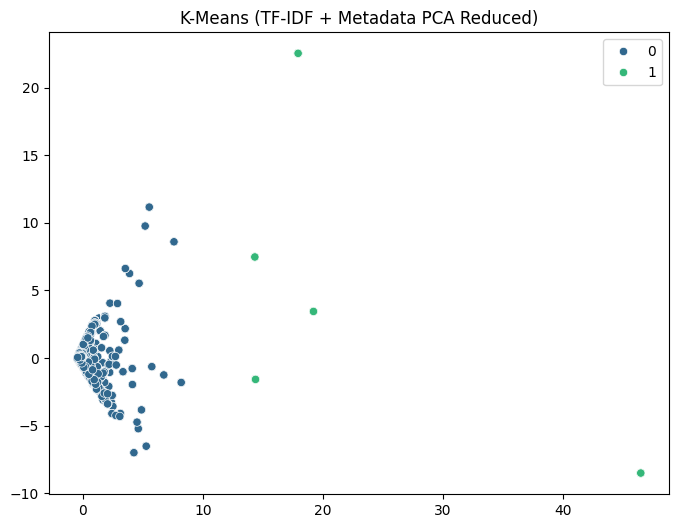

In [5]:
# --- Load tweets ---
import glob

tweet_files = glob.glob("../data/*_tweets.csv")
tweet_dfs = []

for file in tweet_files:
    df = pd.read_csv(file, encoding='latin1')
    
    # Extract type (bot/human) from filename
    if "genuine" in file:
        df["label"] = 0
    else:
        df["label"] = 1
        
    tweet_dfs.append(df)

tweets_df = pd.concat(tweet_dfs, ignore_index=True)
print("Tweets loaded:", tweets_df.shape)

# SAMPLE ONLY 100k tweets for clustering (or smaller if still crashing)
tweets_df = tweets_df.sample(100000, random_state=42)
print("Sampled tweets:", tweets_df.shape)


# --- Basic preprocessing ---
tweets_df["text"] = tweets_df["text"].fillna("").astype(str)

# --- Align tweets to users (merge first BEFORE TF-IDF) ---
merged = pd.merge(tweets_df, full_df, left_on="user_id", right_on="id", suffixes=("_tweet", "_user"))
print("Merged shape:", merged.shape)

# --- TF-IDF Vectorization (AFTER merge so shapes match) ---
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=500, stop_words='english')
X_text = tfidf.fit_transform(merged["text"]).toarray()
print("TF-IDF shape:", X_text.shape)

# --- Numeric features ---
numeric_cols = ["followers_count", "friends_count", "statuses_count", "listed_count"]
X_numeric = merged[numeric_cols].fillna(0).replace([np.inf, -np.inf], 0)
X_numeric_scaled = scaler.fit_transform(X_numeric)

# --- Combine TF-IDF and numeric ---
X_combined = np.hstack([X_text, X_numeric_scaled])
print("Combined feature shape:", X_combined.shape)

# --- K-Means on combined features ---
kmeans_combined = KMeans(n_clusters=2, random_state=42)
kmeans_combined.fit(X_combined)
labels_combined = kmeans_combined.labels_

# --- Evaluate ---
ari_combined = adjusted_rand_score(merged["label_tweet"], labels_combined)
print("Adjusted Rand Index (TF-IDF + Metadata K-Means):", ari_combined)

# --- Visualize with PCA ---
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca_combined = PCA(n_components=2)
X_pca_combined = pca_combined.fit_transform(X_combined)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca_combined[:,0], y=X_pca_combined[:,1], hue=labels_combined, palette="viridis")
plt.title("K-Means (TF-IDF + Metadata PCA Reduced)")
plt.show()


=== Clustering for bot type: Bot


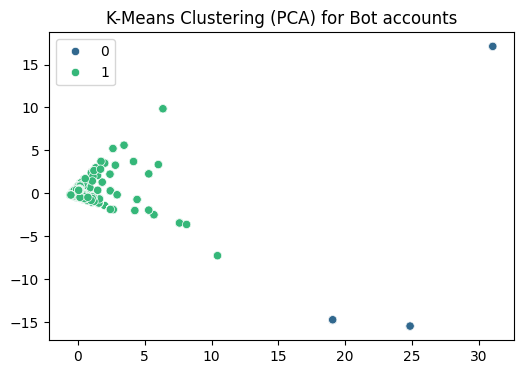


=== Clustering for bot type: Genuine


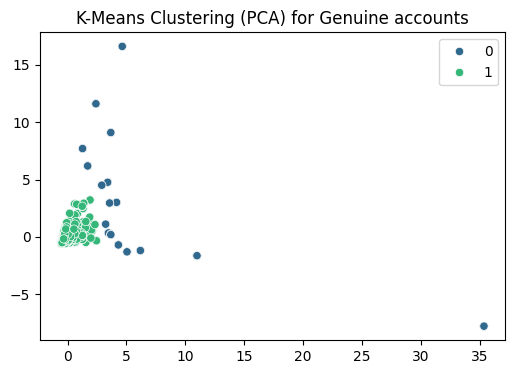

In [6]:
# --- Cluster-by-Bot-Type Analysis ---

# Get unique bot types (from filename used to label tweets)
bot_types = merged["label_tweet"].unique()

for bot_type in bot_types:
    print("\n=== Clustering for bot type:", "Genuine" if bot_type == 0 else "Bot")
    
    # Filter only tweets of this type
    subset = merged[merged["label_tweet"] == bot_type]
    
    # TF-IDF on subset
    tfidf = TfidfVectorizer(max_features=500, stop_words='english')
    X_text_subset = tfidf.fit_transform(subset["text"]).toarray()

    # Numeric features
    X_numeric_subset = subset[numeric_cols].fillna(0).replace([np.inf, -np.inf], 0)
    X_numeric_scaled_subset = scaler.fit_transform(X_numeric_subset)

    # Combine
    X_combined_subset = np.hstack([X_text_subset, X_numeric_scaled_subset])
    
    # Run KMeans
    kmeans_subset = KMeans(n_clusters=2, random_state=42)
    kmeans_subset.fit(X_combined_subset)
    labels_subset = kmeans_subset.labels_
    
    # Visualize
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_combined_subset)

    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_subset, palette="viridis")
    plt.title(f"K-Means Clustering (PCA) for {'Genuine' if bot_type == 0 else 'Bot'} accounts")
    plt.show()


/Users/kpapa/Documents/bot-clustering-project/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


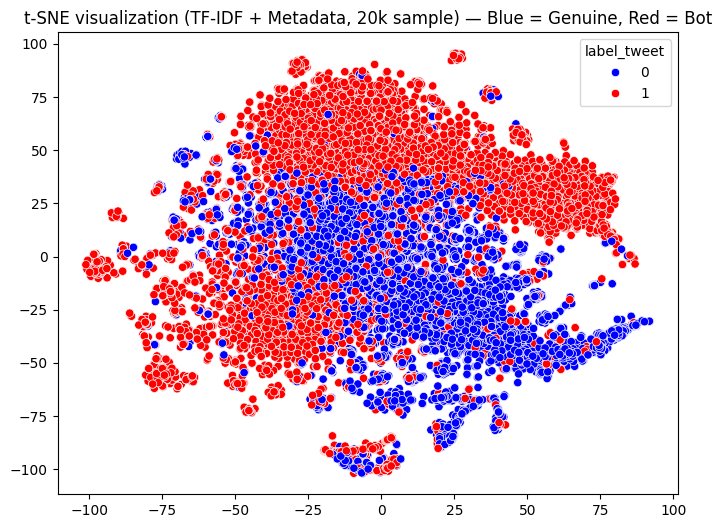

In [7]:
from sklearn.manifold import TSNE

# SAMPLE ONLY 20k from merged
merged_sample = merged.sample(20000, random_state=42)

# Prepare combined features for sampled data
X_text_sample = tfidf.fit_transform(merged_sample["text"]).toarray()

X_numeric_sample = merged_sample[numeric_cols].fillna(0).replace([np.inf, -np.inf], 0)
X_numeric_scaled_sample = scaler.fit_transform(X_numeric_sample)

X_combined_sample = np.hstack([X_text_sample, X_numeric_scaled_sample])

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=50, random_state=42, n_iter=1000)
X_tsne = tsne.fit_transform(X_combined_sample)

# Visualize t-SNE
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=merged_sample["label_tweet"], palette={0: "blue", 1: "red"})
plt.title("t-SNE visualization (TF-IDF + Metadata, 20k sample) — Blue = Genuine, Red = Bot")
plt.show()

/Users/kpapa/Documents/bot-clustering-project/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


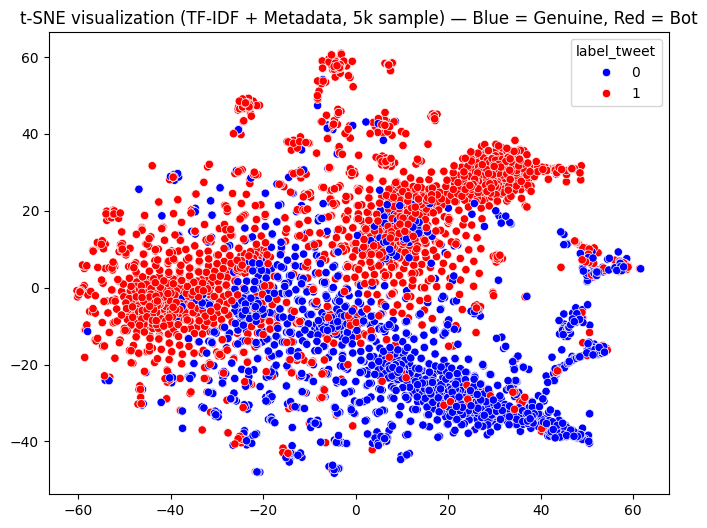

In [8]:
from sklearn.manifold import TSNE

# SAMPLE ONLY 5000 from merged
merged_sample_vis = merged.sample(5000, random_state=42)

# Prepare combined features for sampled data
X_text_sample_vis = tfidf.fit_transform(merged_sample_vis["text"]).toarray()

X_numeric_sample_vis = merged_sample_vis[numeric_cols].fillna(0).replace([np.inf, -np.inf], 0)
X_numeric_scaled_sample_vis = scaler.fit_transform(X_numeric_sample_vis)

X_combined_sample_vis = np.hstack([X_text_sample_vis, X_numeric_scaled_sample_vis])

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=50, random_state=42, n_iter=1000)
X_tsne = tsne.fit_transform(X_combined_sample_vis)

# Visualize t-SNE
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=merged_sample_vis["label_tweet"], palette={0: "blue", 1: "red"})
plt.title("t-SNE visualization (TF-IDF + Metadata, 5k sample) — Blue = Genuine, Red = Bot")
plt.show()


In [9]:
# Add cluster labels back to merged dataframe
merged["cluster"] = labels_combined

# How many clusters?
n_clusters = merged["cluster"].nunique()
print("Clusters found:", n_clusters)

# Show example tweets from each cluster
for cluster_id in range(n_clusters):
    print(f"\n=== Example Tweets from Cluster {cluster_id} ===")
    
    cluster_tweets = merged[merged["cluster"] == cluster_id]
    
    # Sample up to 5 tweets (or fewer if small cluster)
    sample = cluster_tweets.sample(min(5, len(cluster_tweets)), random_state=42)
    
    for idx, row in sample.iterrows():
        print("-", row["text"][:280])  # Limit to 280 characters


Clusters found: 2

=== Example Tweets from Cluster 0 ===
- I wish I could help not just by giving donations. #YolandaPH
- So What is Eating Paleo?  http://t.co/ZVyGdtQ0kX
- Getting ready for bed and commercial for Cat's Meow is on. All I can think of is @CMPunk &amp; I should take a pic of it.
- Faster, faster, faster, until the thrill of speed overcomes the fear of death --  - Hunter Thompson
- I told the man to have a good night and he yelled after me, "Wait come back you're awesome, I LOVE YOU." What the FUCK.

=== Example Tweets from Cluster 1 ===
- Glad you enjoyed it!  RT @jeffrichards: Really getting great info from the @ScreenwritingU rewrite call...
- @lennieddl e aah ,entra no msn a taarde
- "No art passes our conscience in the way film does, and goes directly to our feelings, deep down into the dark... http://t.co/ycnZrkwX
- RT @MJcayabyabINQ: Valenzuela Rep @WinGatchalian74 ,eyed as Binay's senator bet, says party NPC yet to decide if it would support @VPJojoBiâ¦
- RT @eri

In [10]:
# Count number of samples in each cluster
cluster_counts = merged["cluster"].value_counts().sort_index()

print("\n=== Cluster Sizes ===")
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id}: {count} samples")

# Cross-tab of cluster vs true labels (Genuine/Bot)
print("\n=== Cluster vs True Label (Genuine=0, Bot=1) ===")
cross_tab = pd.crosstab(merged["cluster"], merged["label_tweet"], rownames=["Cluster"], colnames=["True Label"])
print(cross_tab)

# OPTIONAL: Save to CSV for use in comps paper later
cross_tab.to_csv("../results/cluster_summary.csv")
print("\nSaved summary to results/cluster_summary.csv")



=== Cluster Sizes ===
Cluster 0: 99749 samples
Cluster 1: 251 samples

=== Cluster vs True Label (Genuine=0, Bot=1) ===
True Label      0      1
Cluster                 
0           42659  57090
1             106    145

Saved summary to results/cluster_summary.csv


In [11]:
# Summary of bot types in tweets
print("\n=== Bot Type Representation (in sampled tweets) ===")
bot_type_counts = tweets_df["label"].value_counts()
print(bot_type_counts)

# Calculate percentage
total = bot_type_counts.sum()
for label, count in bot_type_counts.items():
    pct = (count / total) * 100
    label_name = "Genuine (Human)" if label == 0 else "Bot"
    print(f"{label_name}: {count} accounts ({pct:.2f}%)")


=== Bot Type Representation (in sampled tweets) ===
label
1    57235
0    42765
Name: count, dtype: int64
Bot: 57235 accounts (57.23%)
Genuine (Human): 42765 accounts (42.77%)


In [12]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# --- STEP 1: Run KMeans on all data to get cluster labels (unsupervised signal) ---
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_combined)

# Add cluster label as a feature
X_with_cluster = np.hstack([X_combined, cluster_labels.reshape(-1, 1)])

# --- STEP 2: Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X_with_cluster, merged["label_tweet"], test_size=0.2, random_state=42)

# --- STEP 3: Train simple classifier (Logistic Regression → avoids overfitting too much) ---
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# --- STEP 4: Predict and evaluate ---
y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {acc:.2%}")


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      8558
           1       0.89      0.86      0.88     11442

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000


Accuracy: 86.05%


In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Split first
X_train_df, X_test_df = train_test_split(merged, test_size=0.2, random_state=42)

# TF-IDF only on train
tfidf = TfidfVectorizer(max_features=500, stop_words='english')
X_text_train = tfidf.fit_transform(X_train_df["text"]).toarray()
X_text_test = tfidf.transform(X_test_df["text"]).toarray()

# Metadata scaling only on train
scaler = StandardScaler()
X_numeric_train = scaler.fit_transform(X_train_df[numeric_cols].fillna(0).replace([np.inf, -np.inf], 0))
X_numeric_test = scaler.transform(X_test_df[numeric_cols].fillna(0).replace([np.inf, -np.inf], 0))

# Combine
X_train = np.hstack([X_text_train, X_numeric_train])
X_test = np.hstack([X_text_test, X_numeric_test])

# Labels
y_train = X_train_df["label_tweet"]
y_test = X_test_df["label_tweet"]

# Train and test as before
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_model = rf                                   # what the plotting cell expects
text_feats     = tfidf.get_feature_names_out()  # 500 TF-IDF terms
feature_names  = list(text_feats) + numeric_cols
y_pred = rf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8558
           1       1.00      1.00      1.00     11442

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
import numpy as np

# --- Step 1: PCA reduce to 50 dims ---
print("Running PCA to 50 dimensions...")
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_combined_sample)

print("PCA Reduced shape:", X_pca.shape)

# --- Step 2: t-SNE reduce to 2 dims ---
print("Running t-SNE to 2 dimensions...")
tsne = TSNE(n_components=2, perplexity=50, random_state=42, n_iter=1000)
X_tsne = tsne.fit_transform(X_pca)

print("t-SNE Reduced shape:", X_tsne.shape)

# --- Step 3: KMeans clustering ---
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_tsne)
print("KMeans done.")

# --- Step 4: Agglomerative clustering ---
agglo = AgglomerativeClustering(n_clusters=2)
agglo_labels = agglo.fit_predict(X_tsne)
print("Agglomerative done.")

# --- Step 5: Ensemble clustering ---
ensemble_labels = []

for k, a in zip(kmeans_labels, agglo_labels):
    if k == a:
        ensemble_labels.append(k)
    else:
        ensemble_labels.append(-1)  # disagreement → uncertain

ensemble_labels = np.array(ensemble_labels)
print("Ensemble done.")

# --- Step 6: Evaluate ---
true_labels = merged_sample["label_tweet"].values

ari_kmeans = adjusted_rand_score(true_labels, kmeans_labels)
ari_agglo = adjusted_rand_score(true_labels, agglo_labels)

mask = ensemble_labels != -1
ari_ensemble = adjusted_rand_score(true_labels[mask], ensemble_labels[mask])
ensemble_accuracy = (ensemble_labels[mask] == true_labels[mask]).mean()

print("\n=== Results ===")
print("KMeans ARI:", ari_kmeans)
print("Agglomerative ARI:", ari_agglo)
print("Ensemble ARI (agreed only):", ari_ensemble)
print("Ensemble Accuracy (agreed only):", ensemble_accuracy)
print("Agreed points:", mask.sum())


Running PCA to 50 dimensions...
PCA Reduced shape: (20000, 50)
Running t-SNE to 2 dimensions...


/Users/kpapa/Documents/bot-clustering-project/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE Reduced shape: (20000, 2)
KMeans done.
Agglomerative done.
Ensemble done.

=== Results ===
KMeans ARI: 0.20542478863544825
Agglomerative ARI: 0.15680607978671227
Ensemble ARI (agreed only): 0.19834883349063837
Ensemble Accuracy (agreed only): 0.7227058206607236
Agreed points: 19070


In [21]:
# -----------------------------------------------------------
#  VISUALIZATION SUITE  – Three plots for the paper
#     • t-SNE scatter (GT + K-Means)
#     • Bar chart of ARI vs. ensemble accuracy  (no DBSCAN column)
#     • Random-Forest top-10 feature importances
# -----------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

# ------------------------------------------------------------------
# Helper: ensure y_true, kmeans_labels, ari_* etc. exist
# ------------------------------------------------------------------
if "y_true" not in globals():
    y_true = merged_sample["label_tweet"].values

# -- ensemble labels & metrics (uses kmeans_labels + agglo_labels) --
if "ensemble_labels" not in globals():
    ensemble_labels = np.where(kmeans_labels == agglo_labels,
                               kmeans_labels, -1)

mask_ens          = ensemble_labels != -1
ari_ensemble      = adjusted_rand_score(y_true[mask_ens],
                                        ensemble_labels[mask_ens])
ensemble_accuracy = (ensemble_labels[mask_ens] == y_true[mask_ens]).mean()

# ------------------------------------------------------------------
#  (1)  t-SNE scatter plots
# ------------------------------------------------------------------
for title, labels, fname in [
    ("t-SNE: ground-truth labels", y_true,        "tsne_ground_truth.png"),
    ("t-SNE: K-Means clusters",   kmeans_labels, "tsne_kmeans.png")
]:
    plt.figure(figsize=(6, 5))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
                s=8, c=labels, cmap="tab10", alpha=0.9)
    plt.title(title)
    plt.xlabel("t-SNE dim 1")
    plt.ylabel("t-SNE dim 2")
    plt.tight_layout()
    plt.savefig(fname, dpi=300)
    plt.close()

# ------------------------------------------------------------------
#  (2)  Bar chart – ARI & Ensemble Accuracy  (no DBSCAN bar)
# ------------------------------------------------------------------
algorithms = ["K-Means", "Agglo", "Ensemble"]
ari_values = [ari_kmeans, ari_agglo, ari_ensemble]
acc_values = [0,          0,         ensemble_accuracy]   # accuracy only for Ensemble

x     = np.arange(len(algorithms))
width = 0.35

plt.figure(figsize=(7, 4))
plt.bar(x - width/2, ari_values, width, label="ARI")
plt.bar(x + width/2, acc_values, width, label="Accuracy (Ensemble)")
plt.xticks(x, algorithms)
plt.ylabel("Score")
plt.title("Clustering quality vs. ensemble accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("clustering_metrics.png", dpi=300)
plt.close()

# ------------------------------------------------------------------
#  (3)  Random-Forest top-10 feature importances
# ------------------------------------------------------------------
importances  = rf_model.feature_importances_
sorted_idx   = np.argsort(importances)[::-1][:10]
top_features = [feature_names[i] for i in sorted_idx]
top_imports  = importances[sorted_idx]

plt.figure(figsize=(6, 4.5))
plt.barh(range(len(top_features))[::-1], top_imports, color="steelblue")
plt.yticks(range(len(top_features))[::-1], top_features)
plt.xlabel("Importance")
plt.title("Random-Forest: top-10 features")
plt.tight_layout()
plt.savefig("rf_feature_importance.png", dpi=300)
plt.close()

print("✅ Saved images:",
      "tsne_ground_truth.png, tsne_kmeans.png,",
      "clustering_metrics.png, rf_feature_importance.png")


✅ Saved images: tsne_ground_truth.png, tsne_kmeans.png, clustering_metrics.png, rf_feature_importance.png
